In [493]:
import pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Dataset taken from https://www.kaggle.com/ajay1735/hmeq-data

In [494]:
data = pd.read_csv("hmeq.csv")
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# PART 1
Build a prototype in python using the following algorithms:
* Logistic Regression
* SVMs 
<br>

Include the necessary pre-processing of the data (Including visualisations):
* Exploratory Data Analysis
* Missing Data handling (if any)
* Outlier Detection and Treatment (if any)
* Categorisation of the continuous variables: use WOE encoding
* Use an 80/20 Train - Test Spilt- Stratified
* For Non-Continuous features (if any), use target/mean encoding: https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
<br>

Compare and report performance of models using the following metrics: 
* AUROC
* Area under Precision/Recall Curve
<br>

Scale the scorecard and report an example format: - REPORT
* https://medium.com/@yanhuiliu104/credit-scoring-scorecard-development-process-8554c3492b2b


# Exploratory Data Analysis

In [495]:
data.shape

(5960, 13)

In [496]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [497]:
data.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [498]:
print('Total           : {} instances'.format(len(data)))
count = data['BAD'].value_counts()[0]
print('Loan repaid     : {} instances ({:.2f}%)'.format(count, count/len(data)*100))
count = data['BAD'].value_counts()[1]
print('Client defaulted:  {} instances ({:.2f}%)'.format(count, count/len(data)*100))

Total           : 5960 instances
Loan repaid     : 4771 instances (80.05%)
Client defaulted:  1189 instances (19.95%)


This dataset is quite unbalanced.

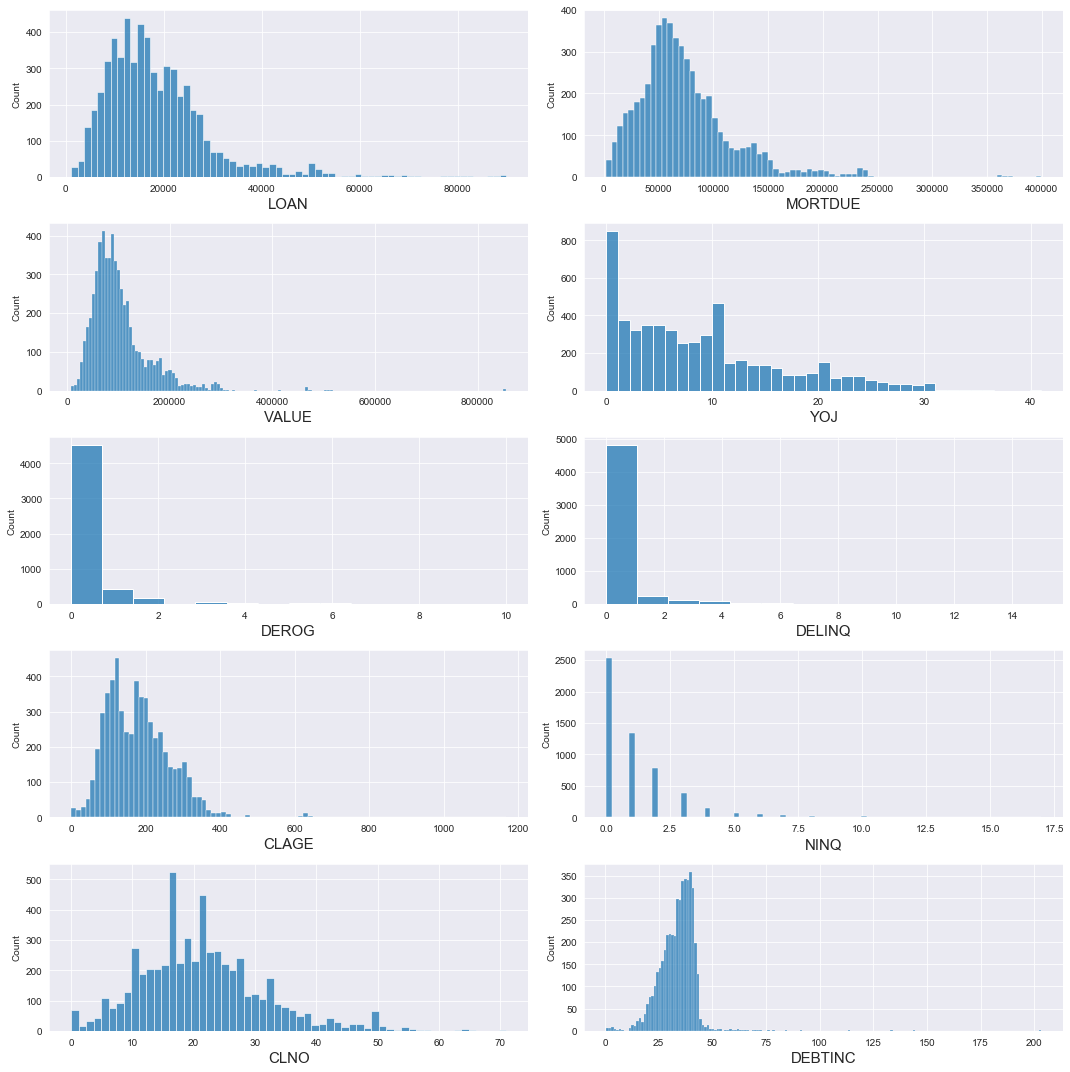

In [499]:
# Column names with numeric values
num_cols = [name for name, dtype in data.dtypes.items() if dtype in ['int64', 'float64']]

sns.set_style('darkgrid')
f, axes = plt.subplots(5,2, figsize=(15,15))  
y = 0;
for name in num_cols[1:]:
    i, j = divmod(y, 2)
    h = sns.histplot(data=data, x=name, ax=axes[i, j])
    h.set_xlabel(name,fontsize=15)
    y = y+1

plt.tight_layout()
plt.show()

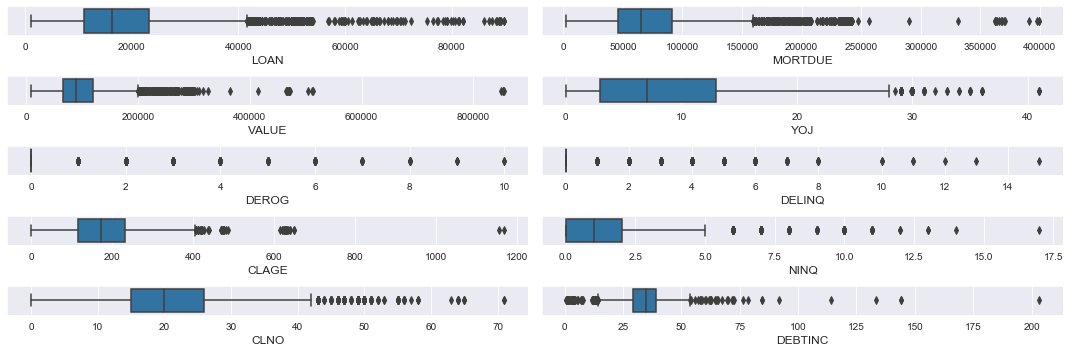

In [500]:
# Column names with numeric values

sns.set_style('darkgrid')
f, axes = plt.subplots(5,2, figsize=(15,5))  
y = 0;
for name in num_cols[1:]:
    i, j = divmod(y, 2)
    b=sns.boxplot(x=data[name], ax=axes[i, j])
    b.set_xlabel(name,fontsize=12)
    y = y+1

plt.tight_layout()
plt.show()

## Missing Data Handling

In [501]:
# Count missing data in each column
data.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Many features have a lot of missing values, it might be unwise to impute these missing data with the median/mean since it will create too much imbalance. I chose to remove all rows which had NaN values.

**Note:** Some preliminary analysis (in another notebook) and modelling showed that REASON was a very irrelevant attribute in the model (See picture below). Therefore, instead of removing those 252 NaN rows and losing possibly valuable instances, I choose to remove the feature itself. 

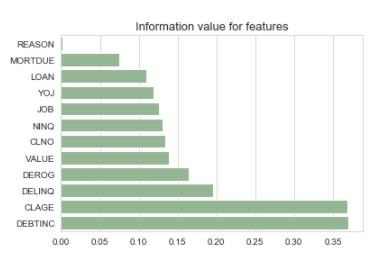

In [502]:
# Remove REASON attribute
data = data.drop("REASON", axis=1)

# Remove NA values
data = data.dropna()

## Outlier Detection and Treatment

In removing outliers, we should be careful not to remove all of them which might lead to information loss. Some preliminary analysis led to believe removing the outliers led to poorer performance of models. **I chose not to remove outliers because they contain important information about whether a client defaulted or not.** In any way, these "outliers" will be binned into categories. 

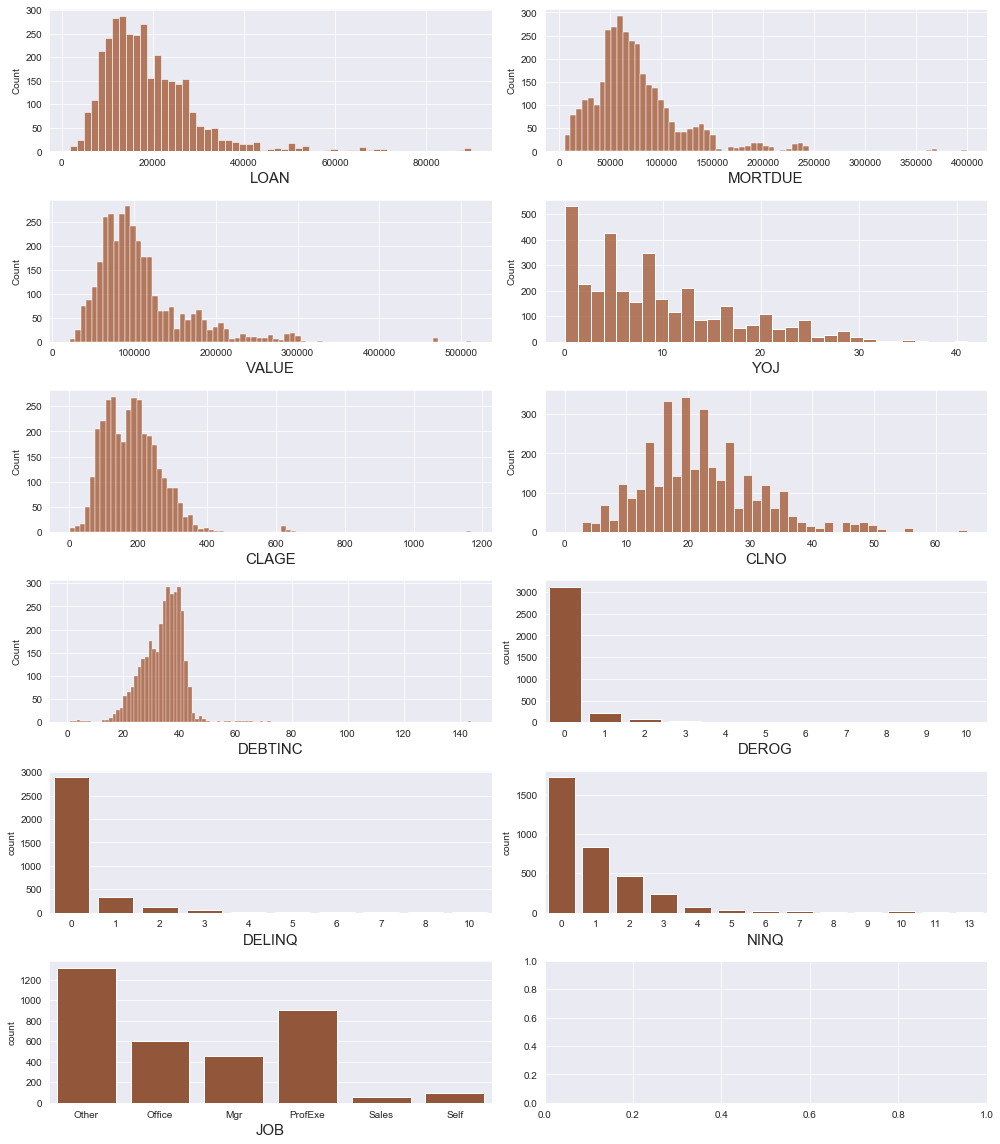

In [503]:
cont_cols = ["LOAN", "MORTDUE", "VALUE", "YOJ", "CLAGE", "CLNO", "DEBTINC"] # Continuous variables
disc_cols = ["DEROG", "DELINQ", "NINQ"] # Discrete variables
cat_cols = ["JOB"] # Categorical variables

# Convert to discrete variables to integer type
data[disc_cols] = data[disc_cols].astype(int)

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(14,16))  
y = 0;
for name in cont_cols + disc_cols + cat_cols:
    i, j = divmod(y, 2)
    
    if name in disc_cols + cat_cols:
        h = sns.countplot(data=data, x=name, ax=axes[i,j], color="sienna")
        
    if name in cont_cols:
        h = sns.histplot(data=data, x=name, ax=axes[i, j], color="sienna")
    h.set_xlabel(name,fontsize=15)
    y = y+1
    
    
plt.tight_layout()
plt.show()

# Categorical features
Categorical features:
* JOB

**Note: I did not use target/mean encoding to encode the categorical features. I used WOE encoding directly instead**

# Binning numerical variables
Continuous variables: 
* LOAN: Amount of the loan request
* MORTDUE: Amount due on existing mortgage
* VALUE: Value of current property
* YOJ: Years at present job
* CLAGE: Age of oldest trade line in months
* DEBTINC: Debt to income ratio
* CLNO: Number of credit lines (is discrete but is considered as continuous because of large number)

Discrete variable:
* DEROG
* DELINQ
* NINQ

Categorise thse variables using Weight of Evidence (WOE) encoding. Information taken from https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Weight-of-Evidence-WOE- and code taken from https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

In [504]:
import re

def discretise(data, col_name, interval, show=True):
    interval.append(max(data[col_name])+0.001)
    binned_data = pd.cut(data[col_name], interval, labels=range(len(interval)-1), right=False, include_lowest=True)
    renamed = dict(Counter(binned_data))
    for i in renamed.keys():
        if interval[i+1] - interval[i] == 1:
            renamed[i] = "{} = {}".format(col_name, interval[i])
        elif i == len(interval) - 2:
            renamed[i] = "{} >= {}".format(col_name, interval[-2])
        else:
            renamed[i] = "{} <= {} < {}".format(interval[i], col_name, interval[i+1])
    data[col_name] = binned_data.replace(renamed)       
    return data

def sort_categories(names):
    mins = []
    for i in names:
        mins.append(min(map(int, re.findall(r"\d+", i))))
    return [x for _, x in sorted(zip(mins, names))]

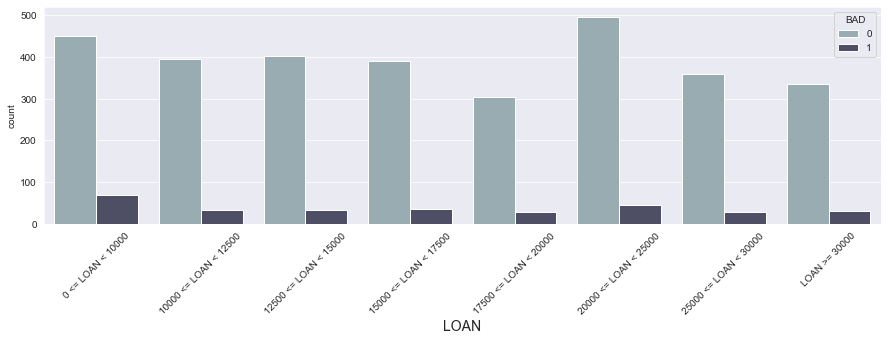

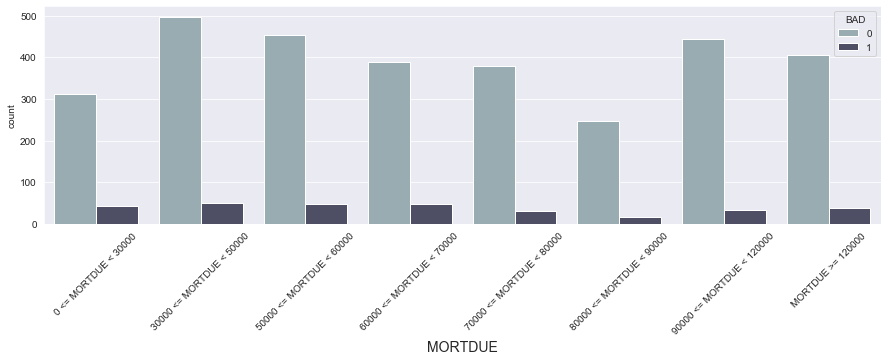

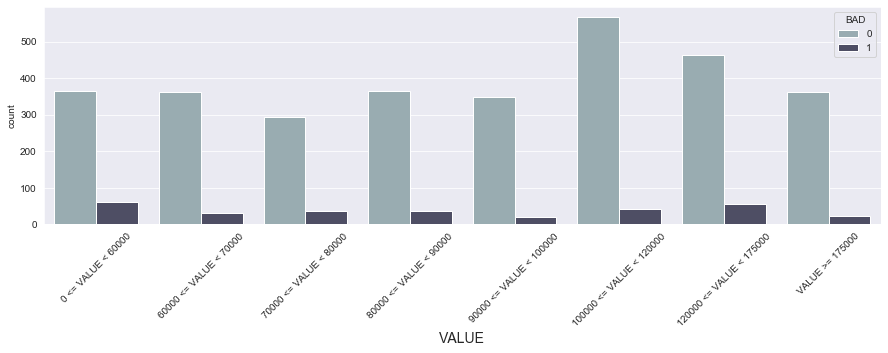

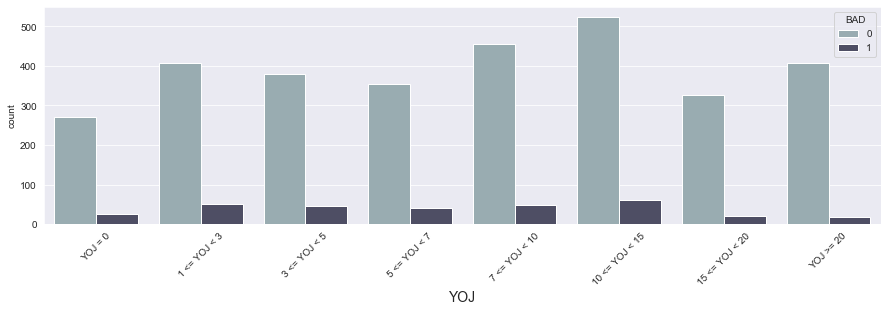

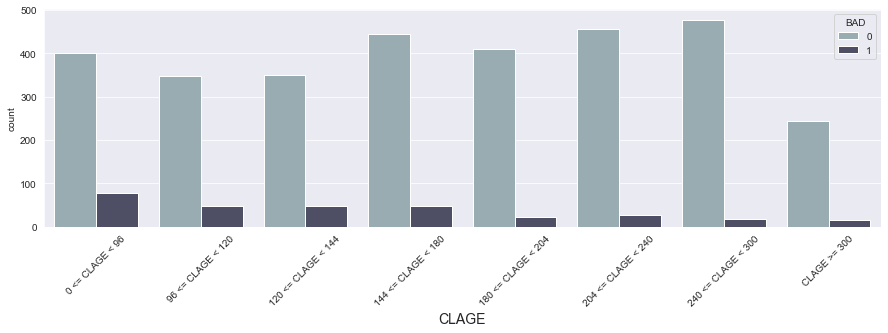

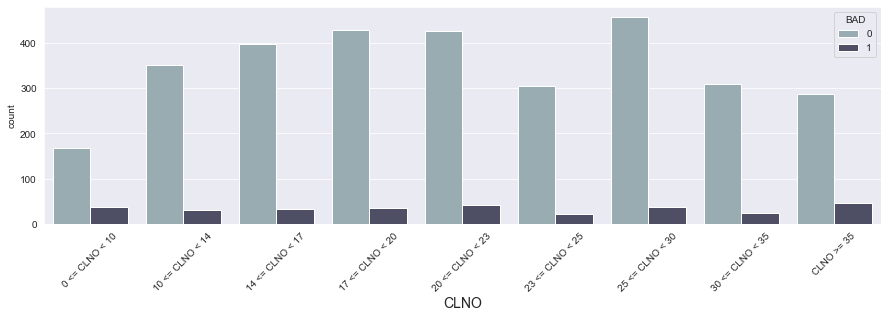

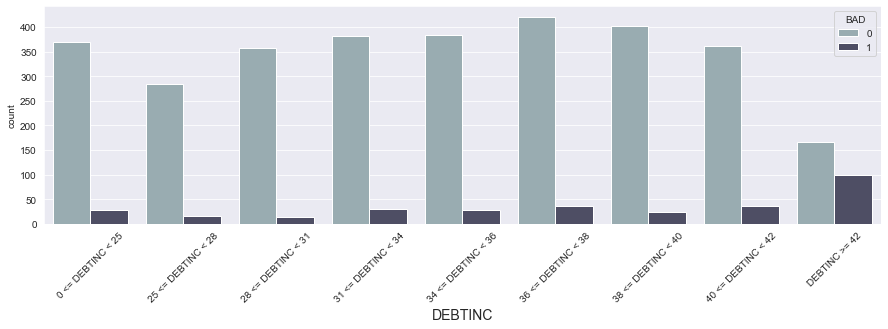

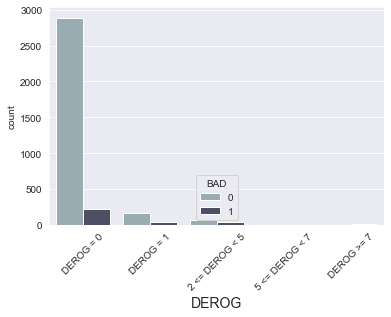

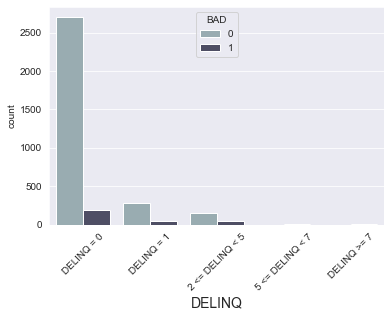

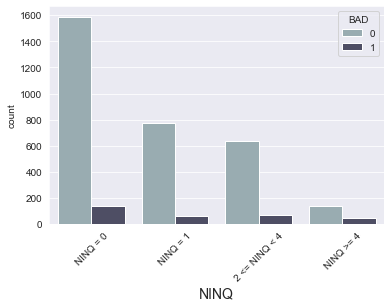

In [505]:
all_cols = cont_cols + disc_cols
data[all_cols] = data[all_cols].astype(float)

intervals = [[0, 10000, 12500, 15000, 17500, 20000, 25000, 30000],    # LOAN
             [0, 30000, 50000, 60000, 70000, 80000, 90000, 120000],   # MORTUDE
             [0, 60000, 70000, 80000, 90000, 100000, 120000, 175000], # VALUE
             [0, 1, 3, 5, 7, 10, 15, 20],                             # YOJ
             [0, 96, 120, 144, 180, 204, 240, 300],                   # CLAGE (equivalent to 8,10,12,15,17,20,25,>25 years)
             [0, 10, 14, 17, 20, 23, 25, 30, 35],                     # CLNO
             [0, 25, 28, 31, 34, 36, 38, 40, 42],                     # DEBTINC
             [0, 1, 2, 5, 7],                                         # DEROG
             [0, 1, 2, 5, 7],                                         # DELINQ
             [0, 1, 2, 4]                                             # NINQ    
            ]
for i in range(len(all_cols)):
    feature = all_cols[i]
    data = discretise(data, feature, intervals[i])
    order = sort_categories(data[feature].unique())
    if feature in cont_cols:
        plt.figure(figsize=(15,4))
    h = sns.countplot(data=data, x=feature, hue="BAD", order=order, palette="bone_r")
    h.set_xlabel(feature, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Weight of Evidence and Information Value

In [506]:
def calc_woe_iv(df, feature, target, pr=0):
    """
    Calculate the WoE and IV for each feature. Returns 
    [0]: the new dataframe with the added weight of evidence feature
    [1]: the information value for that feature
    """
    lst = []

    for val in df[feature].unique():
        lst.append([feature, val, len(df[df[feature] == val]), len(df[(df[feature] == val) & (df[target] == 1)])])
    
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    # Replace infinity WoE to 0.
    data['WoE'].replace({-np.inf: 0, np.inf: 0}, inplace=True)
    data = data.sort_values(by=['Variable', 'Value'], ascending=True)
    
    # Add the WoE to dataframe
    woe_feature = feature + "_woe"
    df[woe_feature] = df[feature]
    df[woe_feature] = df[woe_feature].map(data.set_index('Value')['WoE'])

    # Information value
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()
    
    if pr == 1:
        print(data)
    
    return df, data['IV'].values[0]

In [507]:
all_cols = disc_cols + cont_cols + cat_cols
iv_vals = []
for c in all_cols:
    data, iv = calc_woe_iv(data, c, "BAD")
    iv_vals.append((c, iv))

# sort by IV
iv_vals.sort(key = lambda iv_vals: iv_vals[1])
print("Information Value")
for c, iv in iv_vals:
    print("{:8s}: {}".format(c, iv))

Information Value
MORTDUE : 0.04278573317175621
LOAN    : 0.05005133993678759
YOJ     : 0.10369050094239526
JOB     : 0.1039734643355617
CLNO    : 0.10734598299695529
VALUE   : 0.10966293366787971
NINQ    : 0.17723264616278273
DELINQ  : 0.24259008971366286
DEROG   : 0.2751827078871458
CLAGE   : 0.28425275410949
DEBTINC : 0.6273901424139646


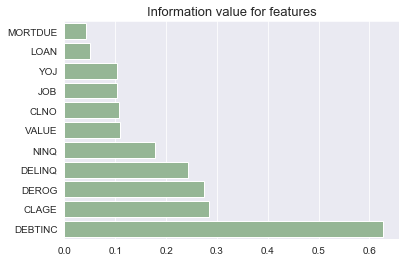

In [508]:
b = sns.barplot(x=[j for i,j in iv_vals], y=[i for i,j in iv_vals], color="darkseagreen")
b.set_title("Information value for features", fontsize=13)
plt.show()

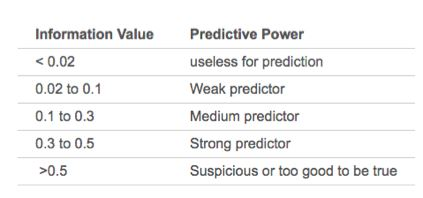

Since MORTDUE and LOAN are very week predictors, remove them.

In [509]:
data = data.drop(["MORTDUE_woe", "LOAN_woe"], axis=1)

**Check if the trends are logical**

In [510]:
for i in ['LOAN', 'MORTDUE']:
    cont_cols.remove(i)

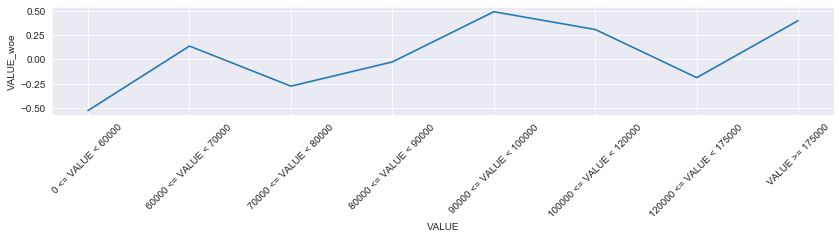

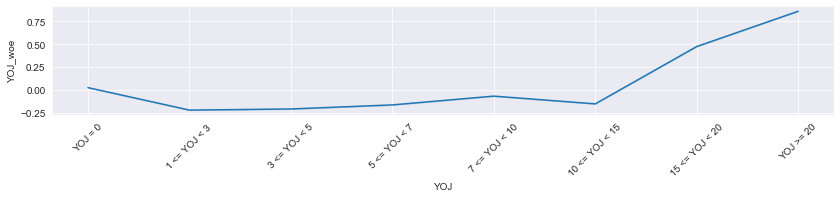

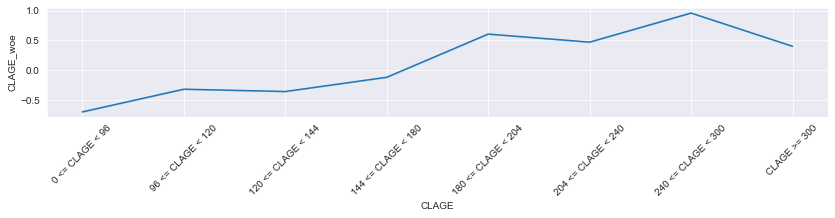

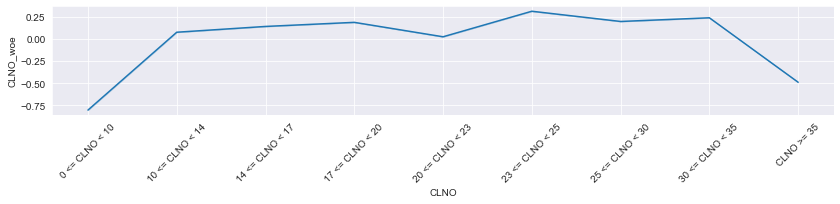

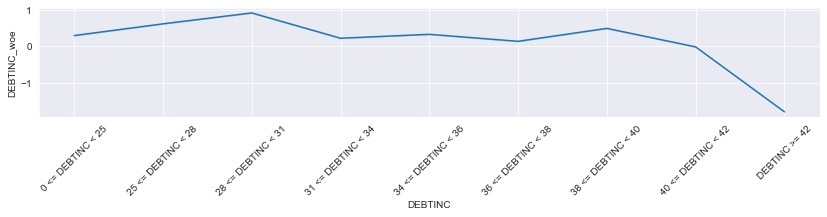

In [511]:
for c in cont_cols:
    plt.figure(figsize=(14,2))
    data[c] = pd.Categorical(data[c], categories=sort_categories(data[c].unique()))
    sns.lineplot(x=c, y=c+"_woe", data=data)
    plt.xticks(rotation=45)
    plt.show()

# Feature analysis

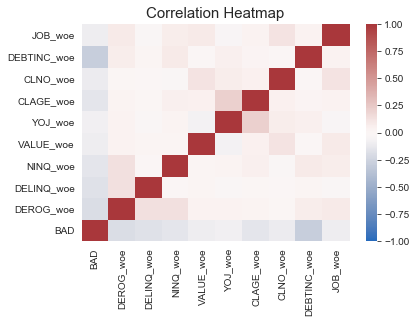

In [512]:
corr = data.drop(["NINQ", "DEROG", "DELINQ"], axis=1).corr()

ax = sns.heatmap(corr,
 vmax=1, vmin=-1, cmap=sns.color_palette("vlag", as_cmap=True));
ax.invert_yaxis()
plt.title("Correlation Heatmap", fontsize=15)

plt.show()

# Model Building

In [513]:
data = data.dropna().reset_index(drop=True)
data.head()

,BAD,LOAN,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,...,DEBTINC,DEROG_woe,DELINQ_woe,NINQ_woe,VALUE_woe,YOJ_woe,CLAGE_woe,CLNO_woe,DEBTINC_woe,JOB_woe
0,1,0 <= LOAN < 10000,30000 <= MORTDUE < 50000,0 <= VALUE < 60000,Other,7 <= YOJ < 10,DEROG = 0,DELINQ = 0,96 <= CLAGE < 120,NINQ = 1,...,36 <= DEBTINC < 38,0.226306,0.319795,0.288524,-0.525650,-0.066118,-0.315355,-0.804364,0.141704,-0.139441
1,1,0 <= LOAN < 10000,0 <= MORTDUE < 30000,0 <= VALUE < 60000,Other,10 <= YOJ < 15,DEROG = 0,DELINQ = 0,0 <= CLAGE < 96,NINQ = 0,...,36 <= DEBTINC < 38,0.226306,0.319795,0.154981,-0.525650,-0.150263,-0.695393,-0.804364,0.141704,-0.139441
2,0,0 <= LOAN < 10000,90000 <= MORTDUE < 120000,120000 <= VALUE < 175000,Office,1 <= YOJ < 3,DEROG = 0,DELINQ = 0,0 <= CLAGE < 96,NINQ = 0,...,31 <= DEBTINC < 34,0.226306,0.319795,0.154981,-0.187016,-0.218166,-0.695393,0.074788,0.226813,0.378284
3,1,0 <= LOAN < 10000,30000 <= MORTDUE < 50000,0 <= VALUE < 60000,Mgr,10 <= YOJ < 15,DEROG = 0,DELINQ = 0,0 <= CLAGE < 96,NINQ = 1,...,38 <= DEBTINC < 40,0.226306,0.319795,0.288524,-0.525650,-0.150263,-0.695393,0.023458,0.498498,-0.132336
4,0,0 <= LOAN < 10000,90000 <= MORTDUE < 120000,100000 <= VALUE < 120000,Office,3 <= YOJ < 5,DEROG = 0,DELINQ = 0,0 <= CLAGE < 96,NINQ = 0,...,28 <= DEBTINC < 31,0.226306,0.319795,0.154981,0.307612,-0.205880,-0.695393,0.074788,0.924066,0.378284


In [514]:
from sklearn.model_selection import train_test_split

x_cols = ["VALUE_woe", "YOJ_woe", "CLAGE_woe", "DEBTINC_woe", 
          "DEROG_woe", "DELINQ_woe","NINQ_woe", "CLNO_woe", "JOB_woe"]

X = data[x_cols]
y = data["BAD"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=305)

### Zero-R classifier (baseline)
Predict the most frequent class. This serves to know how significantly better our other models will do

In [515]:
data["BAD"].value_counts()

0    3126
1     308
Name: BAD, dtype: int64

In [516]:
from sklearn.dummy import DummyClassifier

zero_r = DummyClassifier(strategy='most_frequent')
zero_r.fit(X_train, y_train)
print("Zero-R Accuracy: ", zero_r.score(X_test, y_test))

Zero-R Accuracy:  0.9097525473071325


### Logistic Regression

In [517]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(solver='liblinear')
lgr.fit(X_train,y_train)
print("Basic logistic Regression Accuracy:", lgr.score(X_test,y_test))

Basic logistic Regression Accuracy: 0.9213973799126638


**Hyperparameters tuning with Grid Search**

In [518]:
from sklearn.model_selection import GridSearchCV

# for liblinear solver
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression(solver="liblinear")
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("Logistic Regression with liblinear solver")
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Logistic Regression with liblinear solver
tuned hyperparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.9184564979978158


In [519]:
from sklearn.model_selection import GridSearchCV

# for lbfgs
grid={"C":np.logspace(-3,3,7)}
logreg=LogisticRegression(solver="lbfgs")
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("Logistic Regression with lbfgs solver")
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Logistic Regression with lbfgs solver
tuned hyperparameters :(best parameters)  {'C': 1.0}
accuracy : 0.9173643975245722


**Area under Receiver Operating Characterestic (ROC) Curve and Precision-Recall Curve (PRC)** <br>
Code and information taken from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [532]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def auroc_auprc(fitted_model, X_test, y_test, name):
    """
    Plot the ROC and PRC and calculate the area under those curves
    """
    sns.set_style("darkgrid")
    # ROC
    rc_probs = [0 for _ in range(len(y_test))]
    model_probs = fitted_model.predict_proba(X_test)[:, 1]
    # calculate scores
    model_auc = roc_auc_score(y_test, model_probs)
    print(name, ': ROC AUC = %.3f' % (model_auc))
    rc_fpr, rc_tpr, _ = roc_curve(y_test, rc_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    
    # PRC
    model_precision, model_recall, _ = precision_recall_curve(y_test, model_probs)
    y_pred = fitted_model.predict(X_test)
    model_auc = auc(model_recall, model_precision)
    print(name, ': PRC AUC = %.3f' % (model_auc))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    # Plot the ROC
    ax1.plot(rc_fpr, rc_tpr, linestyle='--', label='Random')
    ax1.plot(model_fpr, model_tpr, marker='.', label=name)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    
    # Plot the PRC
    true_pos = len(y_test[y_test==1]) / len(y_test)
    ax2.plot([0, 1], [true_pos, true_pos], linestyle='--', label='Baseline')
    ax2.plot(model_recall, model_precision, marker='.', label=name)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    plt.show()
    
def show_results(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    print("Accuracy:  ", accuracy_score(y_test,y_pred))
    print("Precision: ", precision_score(y_test,y_pred))
    print("Recall:    ", recall_score(y_test,y_pred))
    print("F1 score:  ", f1_score(y_test,y_pred))

    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=True, 
        cmap='Blues', cbar=False)
    plt.show()
    auroc_auprc(model, X_test, y_test, name)

Accuracy:   0.9184861717612809
Precision:  0.875
Recall:     0.11290322580645161
F1 score:   0.19999999999999998


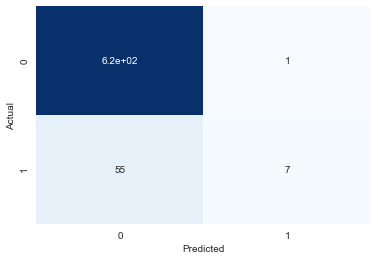

Logistic : ROC AUC = 0.834
Logistic : PRC AUC = 0.468


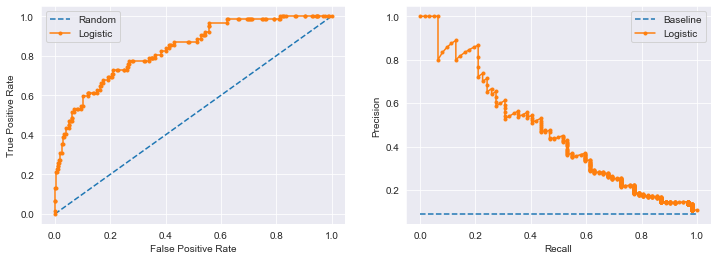

In [521]:
lgr = LogisticRegression(solver="lbfgs", C=0.1)
lgr.fit(X_train, y_train)
show_results(lgr, X_test, y_test, "Logistic")

## Support Vector Machines

**Hyperparameters tuning with Grid Search**

In [522]:
from sklearn import svm

# For linear and sigmoid kernels
grid={"C":np.logspace(-2,2,5)}

linsvc = svm.SVC(kernel="linear")
linsvc_cv=GridSearchCV(linsvc,grid,cv=10)
linsvc_cv.fit(X_train,y_train)

print("Gridsearch for SVC with linear kernel")
print("tuned hyperparameters :(best parameters) ",linsvc_cv.best_params_)
print("accuracy :",linsvc_cv.best_score_)

Gridsearch for SVC with linear kernel
tuned hyperparameters :(best parameters)  {'C': 0.01}
accuracy : 0.9104477611940298


Accuracy:   0.9097525473071325
Precision:  0.0
Recall:     0.0
F1 score:   0.0


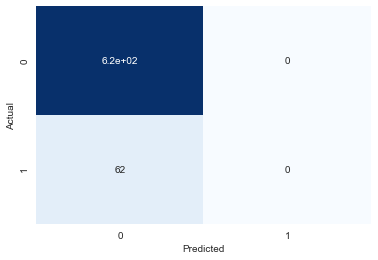

SVM : ROC AUC = 0.610
SVM : PRC AUC = 0.165


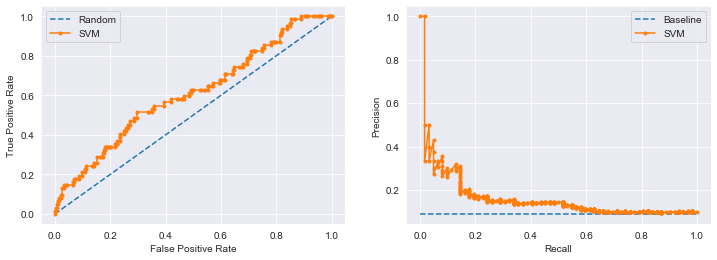

In [523]:
svc = svm.SVC(kernel="linear", C=0.01, probability=True)
svc.fit(X_train, y_train)
show_results(svc, X_test, y_test, "SVM")

### Conclusion

The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets. Overall, logistic regression is the better model. 

# Scale the scorecard

In [524]:
x_cols

['VALUE_woe',
 'YOJ_woe',
 'CLAGE_woe',
 'DEBTINC_woe',
 'DEROG_woe',
 'DELINQ_woe',
 'NINQ_woe',
 'CLNO_woe',
 'JOB_woe']

In [525]:
lgr.coef_

array([[-0.66714206, -0.37959665, -0.81257569, -0.93381724, -0.67454895,
        -0.75580242, -0.53950657, -0.77815608, -0.45506823]])

In [526]:
target_score = 620
target_odds = 50
pdo = 20
factor = pdo/np.log(2)
offset = target_score - factor * np.log(target_odds)

In [527]:
columns = ["feature", "category", "score"]

rows_list = []
alpha = lgr.intercept_[0]
for i, c in enumerate(x_cols):
    name = c[:-4]
    for category in data[name].unique():
        woe = data.loc[data[name] == category, c].unique()[0]  # woe for that category
        beta = lgr.coef_[0][i]  # Model coefficient         
        n = len(data[name].unique())  # Number of categories in that attribute
        score = round(-(woe * beta + alpha/n) * factor + offset/n)
        row = {"feature": name, "category": category, "score": score}
        rows_list.append(row)
scorecard = pd.DataFrame(rows_list)[columns]
scorecard["score"] = scorecard["score"].astype(int) 

In [ ]:
# scorecard.to_csv("scorecard.csv", index=False)

### Get the score for each instance in the dataset and plot the results

In [528]:
cols = [c[:-4] for c in x_cols]
scores = data[cols]
all_scores = []
for r in range(len(scores)):
    score = 0
    for c in cols:
        row_in_card = scorecard[(scorecard["feature"]==c) & (scorecard["category"]==scores.loc[r,c])] 
        score += row_in_card['score'].values[0]
    all_scores.append(score)

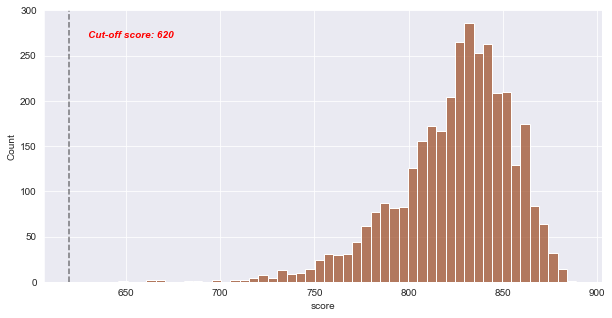

In [529]:
scores["score"] = all_scores
plt.figure(figsize=(10,5))
sns.histplot(data=scores, x="score", color="sienna")
plt.axvline(target_score, color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.text(630, 270, 'Cut-off score: 620', color='red', fontweight='bold', style='italic', fontsize=10)
plt.show()

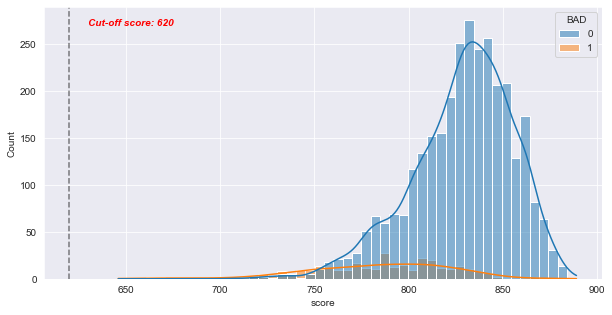

In [530]:
scores["BAD"] = data["BAD"]
scores["score"] = all_scores
plt.figure(figsize=(10,5))
sns.histplot(data=scores, x="score", color="sienna", hue="BAD", kde=True)
plt.axvline(target_score, color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.text(630, 270, 'Cut-off score: 620', color='red', fontweight='bold', style='italic', fontsize=10)
plt.show()